# Self-consistent solution of $\kappa-sech^2$-type electron hole

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import scipy.optimize as op
import plasmapy
from scipy import special as sp
from scipy import integrate
from tqdm import tqdm
import numba as nb
import math
from prettytable import PrettyTable
%config InlineBackend.figure_format = 'svg'

In [2]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'lines.linewidth': 2})

In [3]:
import mpmath as mp
mp.dps=10

def Un_nonvec(u,kappa,n):
    theta = np.sqrt(2.0-3.0/kappa)
    zeta = u/theta
    fac1= (1j/2)**(n+1)
    fac2= np.math.factorial(n)*sp.gamma(2*kappa+n)*sp.gamma(kappa+1)/kappa**(1.5+n/2)/sp.gamma(2*kappa-1)/sp.gamma(kappa+1+n)
    z = 0.5*(1.0+1j*zeta/np.sqrt(kappa))
    hyp = np.complex128(mp.hyp2f1(1+n,2*kappa+n,kappa+1+n,z))
    return (fac1*fac2*hyp).real

def B_kappa_nonvec(u,kappa):
    theta = np.sqrt(2.0-3.0/kappa)
    zeta = u/theta
    fac = (kappa-0.5) / kappa / (kappa+1.0)
    z = 0.5*(1.0+1j*zeta/np.sqrt(kappa))
    hyp = np.complex128(mp.hyp2f1(2,2*kappa+1,kappa+2,z))
    return 1.0/theta**2*fac*hyp.real

def D_kappa_nonvec(u,kappa):
    theta = np.sqrt(2.0-3.0/kappa)
    zeta = u/theta
    fac = 1.5 * (kappa-0.5) * (kappa+0.5) / kappa**2 / (kappa+2.0) / (kappa+3.0) / theta**4
    z = 0.5*(1.0+1j*zeta/np.sqrt(kappa))
    hyp = np.complex128(mp.hyp2f1(4,2*kappa+3,kappa+4,z))
    return fac*hyp.real

Un = np.vectorize(Un_nonvec)
B_kappa = np.vectorize(B_kappa_nonvec)
D_kappa = np.vectorize(D_kappa_nonvec)

In [4]:
u = 1.0
kappa = 5

psi = 0.05
delta = 10
d_min = np.sqrt(8)*np.exp(u**2/2)*(psi/np.pi)**0.25

theta = np.sqrt(2.0-3.0/kappa)
    
# for the given $\psi$ and $\Delta$, calculate the derivatives of $f_t$
dft_dx = (4.0/delta**2 - B_kappa(u,kappa))/np.pi
d3ft_dx3 = 4*(-6.0/psi/delta**2 - D_kappa(u,kappa))/np.pi

print('dft_dx',dft_dx)
print('d3ft_dx3',d3ft_dx3)
#d_min is the minimum of $\Delta$ to maintain a positive $f_t$
print(d_min)

dft_dx -0.026123791830943165
d3ft_dx3 -0.97407021640466
1.6563315230232678


In [5]:
T = 1
L = 8*delta

vmax = 20 
nx = 2000
nv = 30000
dx = L/(nx-1)
dv = 2*vmax/(nv-1)
x = np.linspace(0, L, num=nx, endpoint=True)
v = np.linspace(-vmax, vmax, num=nv, endpoint=True)

In [9]:
xp = (x-L/2)/delta
phi = 0.9*psi*np.cosh(xp)**(-2)
c1 = 0.0
c2 = 0.0
# c1 = phi[0]
# c2 = phi[-1]

In [10]:
#construct the suitable $f_t$ with the shifted kappa distrubiton as $f_u$
@nb.jit
def nonvec_f_fun_sech2(v,phi):
    r = 0
    v_waveframe = v
    w = (v_waveframe**2)/2-phi
    kt2 = kappa*theta**2
    fac = math.gamma(kappa)/math.gamma(kappa-0.5)/(math.pi*kt2)**0.5
    if w>0:
        if v_waveframe<=-(2*phi)**0.5:
            r=fac*(1+(-(2*w)**0.5+u)**2/kt2)**(-kappa)
        elif v_waveframe>(2*phi)**0.5:
            r=fac*(1+( (2*w)**0.5+u)**2/kt2)**(-kappa)
    else:
        r=fac*(1+u**2/kt2)**(-kappa) * (1-w * (2*kappa/(kt2+u**2)) * (1-2*(kappa+1)*u**2/(kt2+u**2)) ) + dft_dx*(-2*w)**0.5 + d3ft_dx3*(-2*w)**1.5/6
    return r
f_fun_sech2 = np.vectorize(nonvec_f_fun_sech2)

In [11]:
#find the self-consistent solution of the distributions $f_t$ and $f_u$
err = 0.0
for count in tqdm(range(6)):
    V,Phi=np.meshgrid(v,phi)
    f_matrix = f_fun_sech2(V,Phi)
    n_vector = f_matrix.sum(axis=1)*dv
    
    dx2 = dx*dx
    laplace = -2.0*np.eye(nx-2,k=0)+np.eye(nx-2,k=1)+np.eye(nx-2,k=-1)
    r = (1.0 - n_vector[1:nx-1])*dx2 + np.dot(laplace,phi[1:nx-1])
    
    # Dirichlet BC phi[0]=c1 phi[-1]=c2
    r[0]  += c1
    r[-1] += c2
    
    m = 2.0 + (n_vector[2:nx]-n_vector[0:nx-2])/(phi[2:nx]-phi[0:nx-2])*dx2
    nr_mat = np.diag(m) - np.eye(nx-2,k=1) - np.eye(nx-2,k=-1)
    dphi = np.linalg.solve(nr_mat,r)
    phi[1:nx-1] += dphi
    
    err = ((dphi/phi[1:nx-1])**2).sum()
    if err<= 1e-6:
        print("Sucess! Iteration counts =", count)
        break
print(err)

 67%|████████████████████████████████████████████████████████                            | 4/6 [01:36<00:48, 24.07s/it]

Sucess! Iteration counts = 4
2.187505760489613e-09


In [12]:
phi_theo = psi*np.cosh((x-L/2)/delta)**(-2)
n_theo = 1+(4*phi_theo - 6*phi_theo**2/psi)/delta**2

In [13]:
V,Phi=np.meshgrid(v,phi)
V,Phi_theo=np.meshgrid(v,phi_theo)
f_matrix = f_fun_sech2(V,Phi)
f_matrix_th = f_fun_sech2(V,Phi_theo)
fv = f_matrix.sum(axis=0)*dx/L
fv_th = f_matrix_th.sum(axis=0)*dx/L

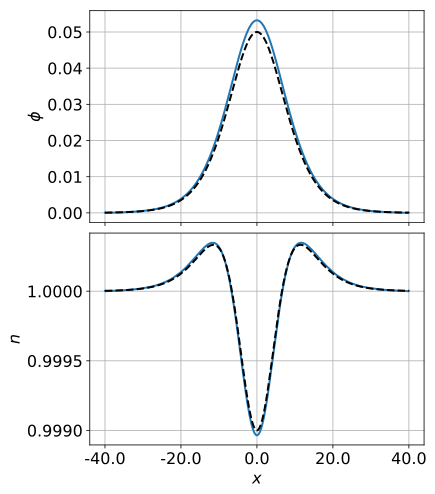

In [14]:
xticks = np.linspace(0,L,num=5)
xticks_show = np.linspace(-L/2,L/2,num=5)

fig = plt.figure(figsize=(6,8))

ax1 = plt.subplot(211)
ax1.plot(x,phi)
ax1.plot(x,phi_theo,color='black',linestyle='--')
ax1.grid()
plt.xticks(xticks,())
ax1.set_ylabel(r'$\phi$')

ax2 = plt.subplot(212)
ax2.plot(x,n_vector)
ax2.plot(x,n_theo,color='black',linestyle='--')
ax2.grid()
plt.xticks(xticks,xticks_show)
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'$n$')

plt.subplots_adjust(hspace = 0.05,wspace=0.1)
# plt.savefig('../1-submit to pop/1-resubmission/verification_psi_n.pdf',dpi=600,bbox_inches = 'tight')
plt.show()

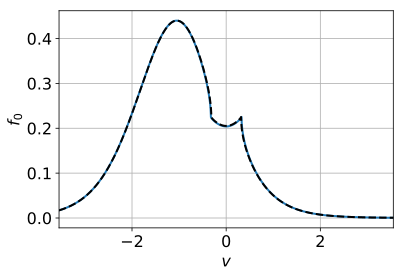

In [15]:
plt.plot(v,f_matrix[int(nx/2),])
plt.plot(v,f_matrix_th[int(nx/2),],color='black',linestyle='--')
plt.xlim(-3*theta,3*theta)
plt.xlabel(r'$v$')
plt.ylabel(r'$f_0$')
plt.grid()

# plt.savefig('../1-submit to pop/1-resubmission/verification_fv.pdf',dpi=600,bbox_inches = 'tight')
plt.show()

In [16]:
#fit the numerical self-consistent potential with $\phi_{num} = \psi_{num} \sech^2 (x/\Delta_{num})$
def phi2_theo(x,a,da):
    xp = (x-L/2)/da
    return a*np.cosh(xp)**(-2)

from scipy.optimize import curve_fit
para2,pcov=curve_fit(phi2_theo,x,phi)
Ddelta = round(abs(para2[1]-delta)/para2[1]*100,2)
Dpsi = round(abs(para2[0]-psi)/para2[0]*100,2)  

print('sech2 fit:',para2)
print('Dpsi     :',Dpsi,'%')
print('Ddelta   :',Ddelta,'%')

sech2 fit: [ 0.05327583 10.10097344]
Dpsi     : 6.15 %
Ddelta   : 1.0 %
